# Q3
Pseudocode:
1. Define functions for x and y components of acceleration as found in part a) for each particle.
2. Instantiate variables N = 1000 steps and h = 0.001 step size, as well as initial conditions for velocity components for each particle (in this case all 0). Let number of particles be an input parameter of the function we are defining. This way we can model any number of particles that is a perfect square.
3. Definine initial conditions for position components as specified. In this case, evenly spaced in a grid of size sqrt of number of particles. 
4. Preallocate memory to an empty arrays of size number of particles by number of iterations by 2 to later store x and y components for position and velocity for each particle at each time step. 
5. Store initial conditions for velocity and position components in the 0th time index in their respective arrays for both x and y components.
6.
7. Implement equations 8-11 component-wise from lab manual with acceleration components mentioned in step 1 as the components of $\vec{f}$.
8. In a for-loop from 2 to N-1 (since we index from zero this corresponds to N iterations in total) update values for trajectory and velocity components according to the series of equations 8-11 in the lab manual (Verlet method) and store the values at each iteration in the appropriate array that we instantiated in step 4. 


In [2]:
import numpy as np

In [11]:
def Potential(r):
    return 4*(r**(-12) + r**(-6))
def Kinetic(vx, vy):
    return 0.5*(vx**2 + vy**2)

In [12]:
def doVerlet(num_particles):
    '''
    Function: DoVerlet: This function performs the Verlet algorithim 
    in order to calculate the position of two particles. 
    Input: A length N array containing ordered pairs [x,y] (length 2 arrays) indicating
    initial conditions for each particle
    '''
    
    # acceleration
    def fx_ij(xi, xj, yi, yj):
        '''
        Function f_ij: Gives the x comp of acceleration experienced by particle i due to
        Lennard-Jones potential wrt particle j.  
        '''
        r = np.sqrt((xj- xi)**2 + (yj - yi)**2)  # separation distance
        return 24 * (xj - xi) * r**(-8) * (2 * r**(-6) - 1)
    
    def fy_ij(xi, xj, yi, yj):
        '''
        Function f_ij: Gives the y comp of acceleration experienced by particle i due to
        Lennard-Jones potential wrt particle j.  
        '''
        r = np.sqrt((xj- xi)**2 + (yj - yi)**2)  # separation distance
        return 24 * (yj - yi) * r**(-8) * (2 * r**(-6) - 1)
    
    def R(xi, xj, yi, yj):
        return np.sqrt((xj- xi)**2 + (yj - yi)**2)
    
    N = 1000 #number of iterations
    h = 0.001 #time step
    
    # Initial Conditions
    Lx = 4.0    # X component of momentum
    Ly = 4.0    # Y component of momentum
    dx = Lx/np.sqrt(num_particles)
    dy = Ly/np.sqrt(num_particles)
    x_grid = np.arange(dx/2, Lx, dx)
    y_grid = np.arange(dy/2, Ly, dy)
    xx_grid, yy_grid = np.meshgrid(x_grid, y_grid)
    x_initial = xx_grid.flatten()
    y_initial = yy_grid.flatten()
    
    #initial rest condition
    v_i = 0.0
    
    #preallocate memory for position velocity, v_prep (ie v(t+h/2))
    r = np.zeros([num_particles, N, 2])
    v = np.zeros([num_particles, N, 2])
    v_prep = np.zeros([num_particles,2])
    
    #set IC
    r[:,0,0] = x_initial
    r[:,0,1] = y_initial
    v[:,0,:] = v_i
    
    #eq 7
    #variables with _prep suffix get updated at each iteration and represent
    #v(t+h/2) in Verlet algorithm (eq 8 - 11) in lab manual
    
    #arrays for storing acceleration due to interaction from each particle
    fx = np.zeros(num_particles)
    fy = np.zeros(num_particles)

    #let's get the first v_prep's using equation 7
    Energy = np.zeros(N)
    Pot = 0.0
    Kin = 0.0
    for i in range(num_particles):
        for j in range(num_particles):
            if i > j: 
                #need to sum up the interactions on each particle from all the others
                fx[i] += fx_ij(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1])
                fy[i] += fy_ij(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1])
                #potential energy
                Pot += Potential(R(r[i,0,0], r[j,0,0], r[i,0,1], r[j,0,1]))
        #kinetic energy
        Kin += Kinetic(v[i, 0, 0], v[i, 0, 1])
        #v(t+h/2)
        v_prep[i, 0] = v[i, 0, 0] + 0.5 * h * fx[i]
        v_prep[i, 1] = v[i, 0, 1] + 0.5 * h * fy[i]
    #total energy for t = 0
    Energy[0] = Kin + Pot
    #now that we've 'prepped' the system we can begin iterating
    for i in range(1,N):
        Pot = 0.0
        Kin = 0.0
        for j in range(num_particles): #need to update each particle at each time step 
            #eq 8
            r[j, i, 0] = r[j, i-1, 0] + h * v_prep[j, 0] #x
            r[j, i, 1] = r[j, i-1, 1] + h * v_prep[j, 1] #y
            #need to sum up the interactions on each particle from all the others
            fx = np.zeros(num_particles)
            fy = np.zeros(num_particles)
            for k in range(num_particles):
                if k > j: 
                    fx[j] += fx_ij(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1])
                    fy[j] += fy_ij(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1])
                    
                    Pot += Potential(R(r[j,i,0], r[k,i,0], r[j,i,1], r[k,i,1]))
            Kin += Kinetic(v[j, i, 0], v[j, i, 1])        
            #eq 9 and 10 combined
            v[j, i, 0] = v_prep[j, 0] + 0.5 * h * fx[j] #vx
            v[j, i, 1] = v_prep[j, 1] + 0.5 * h * fy[j] #vy
            #eq 9 and 11 combined (getting v_prep's for next iteration)
            v_prep[j, 0] = v_prep[j, 0] + h * fx[j]
            v_prep[j, 1] = v_prep[j, 1] + h * fy[j]
            
            r[j, i, 0] = np.mod(r[j, i, 0], Lx)
            r[j, i, 1] = np.mod(r[j, i, 1], Ly)
            
        Energy[i] = Kin + Pot
        
    t = np.linspace(0,h*(N-1),N)
    return v, r, t, Energy

In [14]:
num_particles = 16
v, r, t, Energy = doVerlet(num_particles)

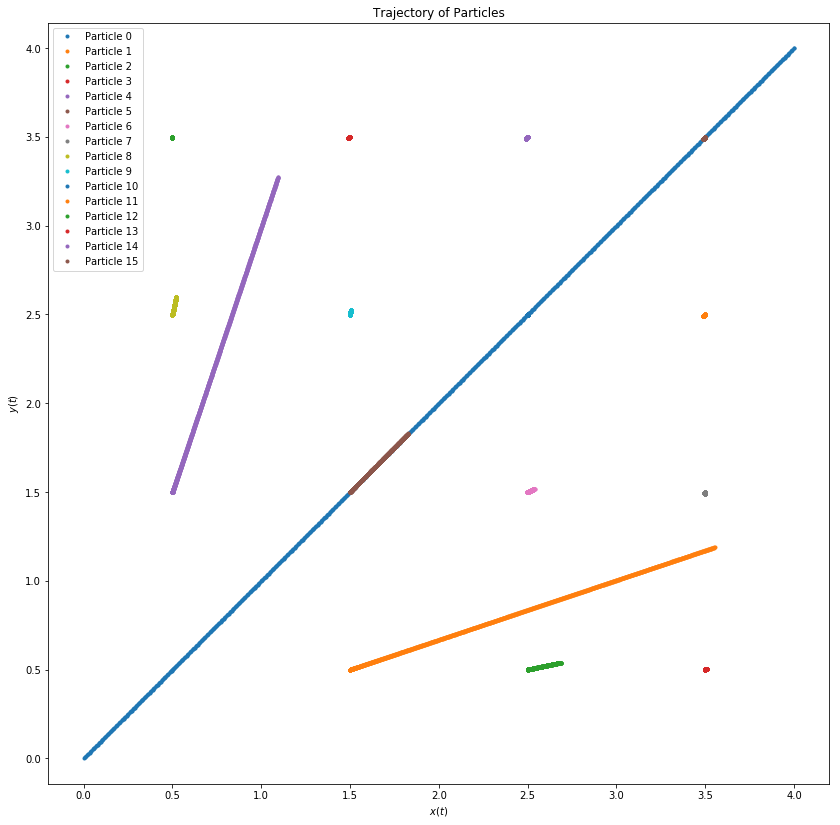

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,14))
plt.title('Trajectory of Particles')
plt.xlabel('$x(t)$')
plt.ylabel('$y(t)$')
for i in range(num_particles):
    lb = 'Particle '+str(i)
    plt.plot(r[i,:,0], r[i,:,1], '.', label = lb)
plt.legend()
plt.axis('equal')
plt.show()

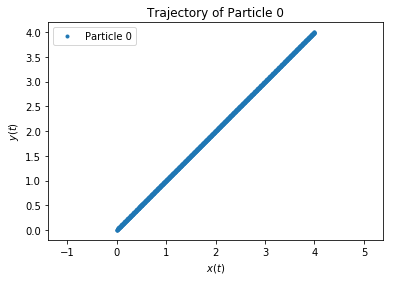

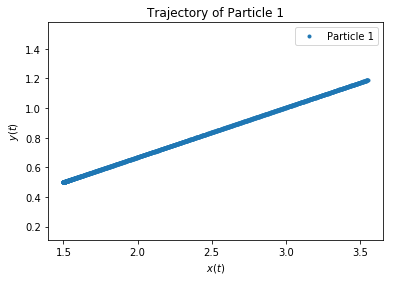

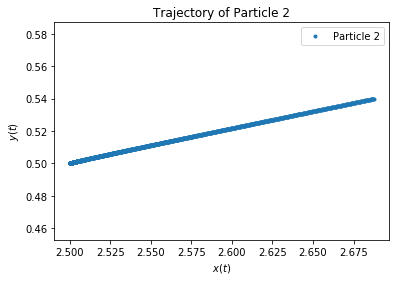

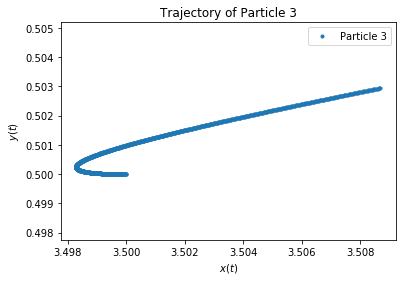

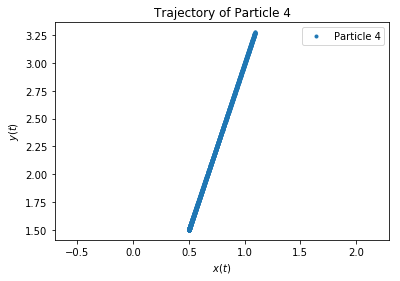

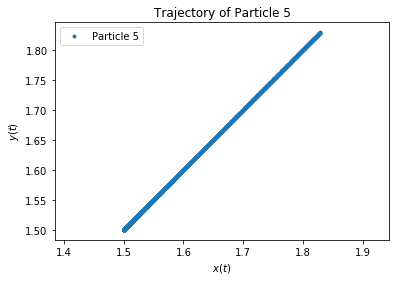

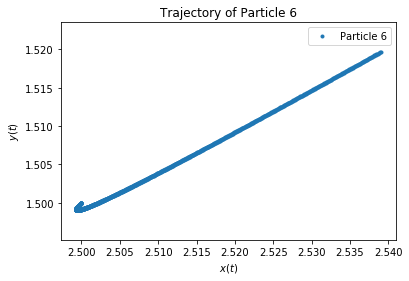

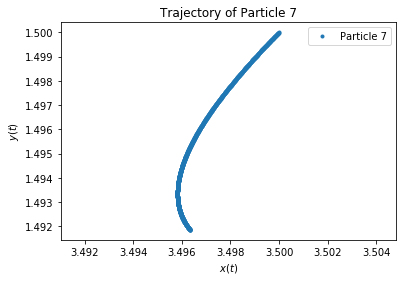

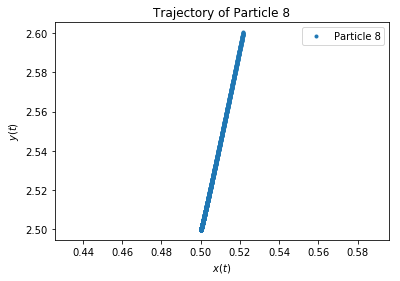

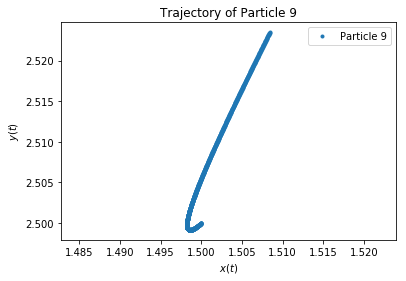

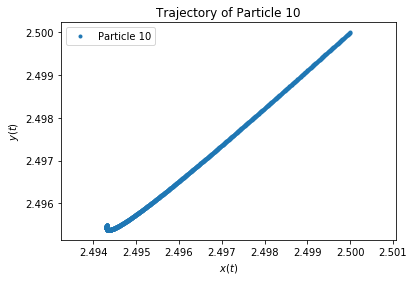

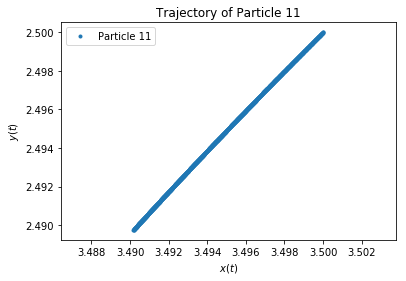

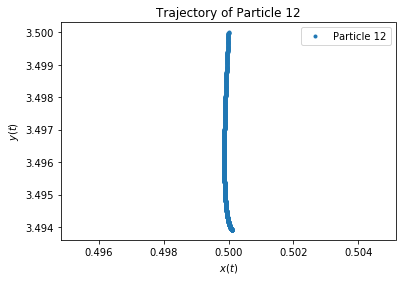

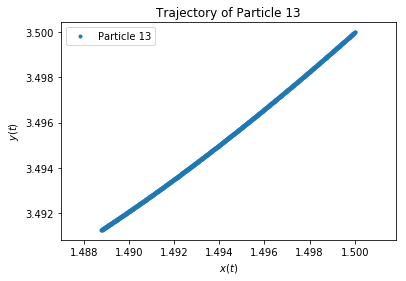

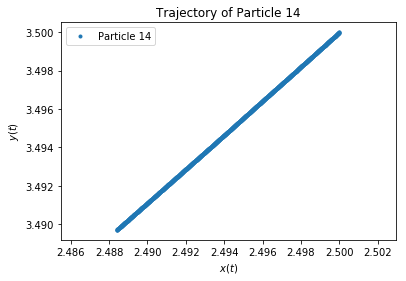

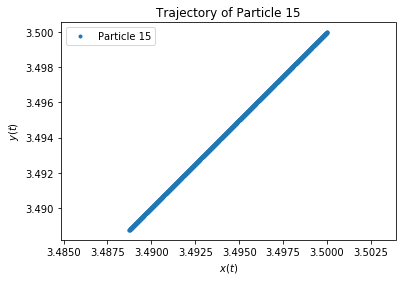

In [16]:
for i in range(num_particles):
    plt.figure()
    plt.title('Trajectory of Particle '+str(i))
    plt.xlabel('$x(t)$')
    plt.ylabel('$y(t)$')
    lb = 'Particle '+str(i)
    plt.plot(r[i,:,0], r[i,:,1], '.', label = lb)
    plt.legend()
    plt.axis('equal')
    plt.show()